In [9]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from datetime import datetime
import warnings
import os
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 80)
print("ILLEGAL FISHING DETECTION - ML CLASSIFICATION PIPELINE")
print("=" * 80)

# ============================================================================
# STEP 1: LOAD ALL DATASETS
# ============================================================================
print("\n[STEP 1] Loading datasets...")

# Load United States EEZ (Exclusive Economic Zone)
print("  - Loading United States EEZ shapefile...")
os.environ['SHAPE_RESTORE_SHX'] = 'YES' # Added to fix missing .shx error
eez_gdf = gpd.read_file('/content/drive/MyDrive/EEZ_land_union_v4_202410/EEZ_land_union_v4_202410.shp')
# The following lines are commented out as 'TERRITORY1' and 'SOVEREIGN1' columns are not present in the shapefile.
# If you need to filter the EEZ data, please inspect the available columns using 'eez_gdf.columns.tolist()'
# and update the filtering logic accordingly.
# eez_gdf = eez_gdf[eez_gdf['TERRITORY1'].str.contains('United States', case=False, na=False) |
#                    eez_gdf['SOVEREIGN1'].str.contains('United States', case=False, na=False)]
print(f"    Loaded {len(eez_gdf)} US EEZ polygons")

# Load SAR data (Synthetic Aperture Radar)
sar_directory = '/content/drive/MyDrive/SARdata_2017to2024'
all_files = [os.path.join(sar_directory, f) for f in os.listdir(sar_directory) if f.endswith('.csv')]
print("  - Loading SAR data...")
# Create a list to store DataFrames
df_list = []

# Read each CSV file into a DataFrame and add it to the list
for file in all_files:
    df = pd.read_csv(file)
    df_list.append(df)

# Concatenate all DataFrames in the list
sar_df = pd.concat(df_list, ignore_index=True)
print(f"    Loaded {len(sar_df)} SAR records")

# Load Marine Protected Areas
print("  - Loading Marine Protected Areas...")
mpa_df = pd.read_csv('/content/drive/MyDrive/NOAA_Marine_Protected_Areas_Inventory_2024.csv')
print(f"    Loaded {len(mpa_df)} MPA records")

# # Writing data to csv files (Note: 'ais_gdf' is not defined here, this line will be commented out for now)
# ais_gdf.to_csv('/content/drive/MyDrive/ais_data.csv', index=False)
sar_df.to_csv('/content/drive/MyDrive/sar_data.csv', index=False)
mpa_df.to_csv('/content/drive/MyDrive/mpa_data.csv', index=False)
eez_gdf.to_csv('/content/drive/MyDrive/eez_data.csv', index=False)

print("  ✓ All datasets loaded")

ILLEGAL FISHING DETECTION - ML CLASSIFICATION PIPELINE

[STEP 1] Loading datasets...
  - Loading United States EEZ shapefile...
    Loaded 328 US EEZ polygons
  - Loading SAR data...
    Loaded 487328 SAR records
  - Loading Marine Protected Areas...
    Loaded 981 MPA records
  ✓ All datasets loaded


In [16]:
# ============================================================================
# STEP 2: PREPARE SPATIAL DATA
# ============================================================================
print("\n[STEP 2] Preparing spatial data...")

target_crs = 'EPSG:4326'  # WGS84
# Set the CRS for eez_gdf if it's naive, assuming it's already in EPSG:4326
if eez_gdf.crs is None:
    eez_gdf = eez_gdf.set_crs(target_crs, allow_override=True)
eez_gdf = eez_gdf.to_crs(target_crs)

# Convert SAR data to GeoDataFrame
sar_lat_col = 'latitude' if 'latitude' in sar_df.columns else 'lat'
sar_lon_col = 'longitude' if 'longitude' in sar_df.columns else 'lon'
sar_geometry = [Point(xy) for xy in zip(sar_df[sar_lon_col], sar_df[sar_lat_col])]
sar_gdf = gpd.GeoDataFrame(sar_df, geometry=sar_geometry, crs=target_crs)

# Convert MPA data to GeoDataFrame
print(f"  - MPA DataFrame columns: {mpa_df.columns.tolist()}") # Added to inspect columns

# Correctly identify latitude and longitude columns in mpa_df
if 'Latitude' in mpa_df.columns:
    mpa_lat_col = 'Latitude'
elif 'latitude' in mpa_df.columns:
    mpa_lat_col = 'latitude'
else:
    mpa_lat_col = 'lat'

if 'Longitude' in mpa_df.columns:
    mpa_lon_col = 'Longitude'
elif 'longitude' in mpa_df.columns:
    mpa_lon_col = 'longitude'
else:
    mpa_lon_col = 'lon'

mpa_geometry = [Point(xy) for xy in zip(mpa_df[mpa_lon_col], mpa_df[mpa_lat_col])]
mpa_gdf = gpd.GeoDataFrame(mpa_df, geometry=mpa_geometry, crs=target_crs)

print("  ✓ All datasets converted to common CRS (EPSG:4326)")


[STEP 2] Preparing spatial data...
  - MPA DataFrame columns: ['FID', 'Site_ID', 'Site_Name', 'Gov_Level', 'State', 'Prot_Lvl', 'Mgmt_Agen', 'Mgmt_Plan', 'Pri_Con_Fo', 'Cons_Focus', 'Fish_Rstr', 'Prot_Focus', 'Permanence', 'Constancy', 'Estab_Yr', 'Anchor', 'Vessel', 'IUCN_MPA', 'IUCNcat', 'Category', 'Marine', 'URL', 'WDPA_Cd', 'ProSeasID', 'Design', 'AreaKm', 'AreaMar', 'MarPercent', 'AreaNT', 'Longitude', 'Latitude', 'VxCount', 'SHAPE_Leng', 'Shape__Area', 'Shape__Length']
  ✓ All datasets converted to common CRS (EPSG:4326)


In [17]:
# ============================================================================
# STEP 3: FILTER TO UNITED STATES REGION
# ============================================================================
print("\n[STEP 3] Filtering data to United States region...")

us_bounds = {
    'min_lon': -180,
    'max_lon': -65,
    'min_lat': 18,
    'max_lat': 72
}

# Filter SAR data to US EEZ
print("  - Filtering SAR data within United States EEZ...")
sar_us = gpd.sjoin(sar_gdf, eez_gdf, how='inner', predicate='within')
print(f"    Filtered to {len(sar_us)} SAR records in United States")

# Filter MPA data to US region
print("  - Filtering MPA data to United States region...")
mpa_us = mpa_gdf[
    (mpa_gdf[mpa_lon_col] >= us_bounds['min_lon']) &
    (mpa_gdf[mpa_lon_col] <= us_bounds['max_lon']) &
    (mpa_gdf[mpa_lat_col] >= us_bounds['min_lat']) &
    (mpa_gdf[mpa_lat_col] <= us_bounds['max_lat'])
]
print(f"    Filtered to {len(mpa_us)} MPA records in United States")




[STEP 3] Filtering data to United States region...
  - Filtering SAR data within United States EEZ...
    Filtered to 486111 SAR records in United States
  - Filtering MPA data to United States region...
    Filtered to 910 MPA records in United States


In [19]:
# ============================================================================
# STEP 4: SPATIAL JOINS
# ============================================================================
print("\n[STEP 4] Performing spatial joins...")

# Add MPA information to SAR detections
print("  - Checking which SAR detections are near MPAs...")
mpa_us_buffered = mpa_us.copy()
mpa_us_buffered['geometry'] = mpa_us_buffered.geometry.buffer(0.009)  # ~1km buffer
sar_with_mpa = gpd.sjoin(sar_us, mpa_us_buffered, how='left', predicate='intersects', rsuffix='_mpa')
print(f"    Joined dataset size: {len(sar_with_mpa)} records")


[STEP 4] Performing spatial joins...
  - Checking which SAR detections are near MPAs...
    Joined dataset size: 486111 records


In [20]:
# ============================================================================
# STEP 5: FEATURE ENGINEERING
# ============================================================================
print("\n[STEP 5] Engineering features for ML model...")

df = sar_with_mpa.copy()

# Binary feature: Is detection in MPA?
df['in_mpa'] = df['index_right'].notna().astype(int)

# Calculate distance to nearest MPA (for those not in MPA)
print("  - Calculating distances to MPAs...")
def calc_distance_to_nearest_mpa(point, mpa_gdf):
    distances = mpa_gdf.geometry.distance(point)
    return distances.min() if len(distances) > 0 else np.nan

df['distance_to_mpa'] = df.geometry.apply(lambda x: calc_distance_to_nearest_mpa(x, mpa_us))

# Spatial features
df['latitude'] = df.geometry.y
df['longitude'] = df.geometry.x

# Distance to shore (proxy using distance from coast approximation)
df['distance_to_shore_proxy'] = np.sqrt(
    (df['latitude'] - 40)**2 + (df['longitude'] + 95)**2
)

# Depth proxy (deeper water = farther from coast typically)
df['depth_proxy'] = df['distance_to_shore_proxy'] * 10  # Simplified proxy

# Time-based features (if timestamp exists)
if 'timestamp' in df.columns or 'date' in df.columns or 'time' in df.columns:
    time_col = 'timestamp' if 'timestamp' in df.columns else ('date' if 'date' in df.columns else 'time')
    df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
    df['hour'] = df[time_col].dt.hour
    df['day_of_week'] = df[time_col].dt.dayofweek
    df['month'] = df[time_col].dt.month
    df['year'] = df[time_col].dt.year
    df['is_night'] = ((df['hour'] >= 20) | (df['hour'] <= 6)).astype(int)
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

    # Fishing season indicators (varies by region)
    df['is_peak_fishing_season'] = df['month'].isin([5, 6, 7, 8, 9]).astype(int)

# SAR-specific features
if 'intensity' in df.columns or 'backscatter' in df.columns:
    intensity_col = 'intensity' if 'intensity' in df.columns else 'backscatter'
    df['radar_intensity'] = pd.to_numeric(df[intensity_col], errors='coerce')
    df['high_intensity'] = (df['radar_intensity'] > df['radar_intensity'].quantile(0.75)).astype(int)

if 'vessel_length' in df.columns or 'length' in df.columns:
    length_col = 'vessel_length' if 'vessel_length' in df.columns else 'length'
    df['vessel_length'] = pd.to_numeric(df[length_col], errors='coerce')
    df['large_vessel'] = (df['vessel_length'] > 50).astype(int)  # > 50m

# Clustering features - detect multiple vessels in same area
print("  - Computing spatial clustering features...")
from scipy.spatial import cKDTree

coords = np.column_stack([df['longitude'], df['latitude']])
tree = cKDTree(coords)

# Count nearby detections (within ~5km = 0.045 degrees)
nearby_counts = tree.query_ball_point(coords, 0.045, return_length=True)
df['nearby_vessel_count'] = nearby_counts - 1  # Subtract self

df['is_in_cluster'] = (df['nearby_vessel_count'] > 3).astype(int)

# Geographic zones (divide US waters into zones)
df['zone_latitude'] = pd.cut(df['latitude'], bins=5, labels=False)
df['zone_longitude'] = pd.cut(df['longitude'], bins=5, labels=False)

# Create interaction features
df['mpa_night_interaction'] = df['in_mpa'] * df.get('is_night', 0)
df['mpa_cluster_interaction'] = df['in_mpa'] * df['is_in_cluster']

print("  ✓ Feature engineering complete")




[STEP 5] Engineering features for ML model...
  - Calculating distances to MPAs...
  - Computing spatial clustering features...
  ✓ Feature engineering complete


In [21]:
# ============================================================================
# STEP 6: CREATE TARGET VARIABLE
# ============================================================================
print("\n[STEP 6] Creating target variable...")

# Create synthetic labels based on suspicious patterns
# NOTE: Replace this with actual ground truth labels in production
suspicious_score = 0

# High suspicion factors
if 'in_mpa' in df.columns:
    suspicious_score += df['in_mpa'] * 3  # In MPA = very suspicious

if 'is_night' in df.columns:
    suspicious_score += df['is_night'] * 2  # Night fishing = suspicious

if 'is_in_cluster' in df.columns:
    suspicious_score += df['is_in_cluster'] * 2  # Clustered vessels = suspicious

# Medium suspicion factors
if 'nearby_vessel_count' in df.columns:
    suspicious_score += (df['nearby_vessel_count'] > 5).astype(int) * 1

if 'distance_to_mpa' in df.columns:
    suspicious_score += (df['distance_to_mpa'] < 0.05).astype(int) * 1  # Very close to MPA

# Create binary target (threshold of 4 = at least 2 high factors or equivalent)
df['illegal_fishing'] = (suspicious_score >= 4).astype(int)

print(f"  ✓ Target variable created")
print(f"    Illegal fishing cases: {df['illegal_fishing'].sum()} ({df['illegal_fishing'].mean()*100:.2f}%)")
print(f"    Legal fishing cases: {(1-df['illegal_fishing']).sum()} ({(1-df['illegal_fishing'].mean())*100:.2f}%)")




[STEP 6] Creating target variable...
  ✓ Target variable created
    Illegal fishing cases: 400472 (82.38%)
    Legal fishing cases: 85639 (17.62%)


In [22]:
# ============================================================================
# STEP 7: PREPARE DATA FOR ML
# ============================================================================
print("\n[STEP 7] Preparing data for machine learning...")

# Select features for modeling
feature_columns = [
    'in_mpa', 'distance_to_mpa', 'latitude', 'longitude',
    'distance_to_shore_proxy', 'depth_proxy',
    'nearby_vessel_count', 'is_in_cluster',
    'zone_latitude', 'zone_longitude'
]

# Add optional features if they exist
optional_features = [
    'hour', 'day_of_week', 'month', 'is_night', 'is_weekend',
    'is_peak_fishing_season', 'radar_intensity', 'high_intensity',
    'vessel_length', 'large_vessel', 'mpa_night_interaction',
    'mpa_cluster_interaction'
]

for feat in optional_features:
    if feat in df.columns:
        feature_columns.append(feat)

# Remove any rows with missing target or critical features
df_model = df[feature_columns + ['illegal_fishing']].dropna()

X = df_model[feature_columns]
y = df_model['illegal_fishing']

print(f"  ✓ Feature matrix shape: {X.shape}")
print(f"  ✓ Features used ({len(feature_columns)}): {feature_columns}")

# Check class balance
print(f"\n  Class distribution:")
print(f"    Legal (0): {(y == 0).sum()} samples ({(y == 0).mean()*100:.1f}%)")
print(f"    Illegal (1): {(y == 1).sum()} samples ({(y == 1).mean()*100:.1f}%)")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n  ✓ Training set: {X_train.shape[0]} samples")
print(f"  ✓ Test set: {X_test.shape[0]} samples")




[STEP 7] Preparing data for machine learning...
  ✓ Feature matrix shape: (486111, 18)
  ✓ Features used (18): ['in_mpa', 'distance_to_mpa', 'latitude', 'longitude', 'distance_to_shore_proxy', 'depth_proxy', 'nearby_vessel_count', 'is_in_cluster', 'zone_latitude', 'zone_longitude', 'hour', 'day_of_week', 'month', 'is_night', 'is_weekend', 'is_peak_fishing_season', 'mpa_night_interaction', 'mpa_cluster_interaction']

  Class distribution:
    Legal (0): 85639 samples (17.6%)
    Illegal (1): 400472 samples (82.4%)

  ✓ Training set: 388888 samples
  ✓ Test set: 97223 samples


In [23]:
# ============================================================================
# STEP 8: TRAIN RANDOM FOREST CLASSIFIER
# ============================================================================
print("\n[STEP 8] Training Random Forest classifier...")

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1,
    verbose=1
)

rf_model.fit(X_train_scaled, y_train)
print("  ✓ Random Forest model trained")

# Predictions
rf_pred = rf_model.predict(X_test_scaled)
rf_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("\n  Random Forest Performance:")
print("  " + "-" * 60)
print(classification_report(y_test, rf_pred, target_names=['Legal', 'Illegal'],
                          zero_division=0, digits=4))
print(f"  ROC-AUC Score: {roc_auc_score(y_test, rf_pred_proba):.4f}")

# Feature importance
rf_feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n  Top 10 Most Important Features:")
for idx, row in rf_feature_importance.head(10).iterrows():
    print(f"    {row['feature']}: {row['importance']:.4f}")



[STEP 8] Training Random Forest classifier...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 44 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    1.4s


  ✓ Random Forest model trained

  Random Forest Performance:
  ------------------------------------------------------------
              precision    recall  f1-score   support

       Legal     0.9998    1.0000    0.9999     17128
     Illegal     1.0000    1.0000    1.0000     80095

    accuracy                         1.0000     97223
   macro avg     0.9999    1.0000    0.9999     97223
weighted avg     1.0000    1.0000    1.0000     97223

  ROC-AUC Score: 1.0000

  Top 10 Most Important Features:
    mpa_cluster_interaction: 0.2262
    nearby_vessel_count: 0.2181
    is_in_cluster: 0.1802
    is_night: 0.1527
    mpa_night_interaction: 0.1434
    hour: 0.0564
    longitude: 0.0052
    distance_to_mpa: 0.0041
    distance_to_shore_proxy: 0.0036
    latitude: 0.0033


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.2s finished
[Parallel(n_jobs=44)]: Using backend ThreadingBackend with 44 concurrent workers.
[Parallel(n_jobs=44)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=44)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=44)]: Using backend ThreadingBackend with 44 concurrent workers.
[Parallel(n_jobs=44)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=44)]: Done 200 out of 200 | elapsed:    0.1s finished


In [24]:
# ============================================================================
# STEP 9: TRAIN XGBOOST CLASSIFIER
# ============================================================================
print("\n[STEP 9] Training XGBoost classifier...")

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss',
    n_jobs=-1,
    verbosity=1
)

xgb_model.fit(X_train_scaled, y_train)
print("  ✓ XGBoost model trained")

# Predictions
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("\n  XGBoost Performance:")
print("  " + "-" * 60)
print(classification_report(y_test, xgb_pred, target_names=['Legal', 'Illegal'],
                          zero_division=0, digits=4))
print(f"  ROC-AUC Score: {roc_auc_score(y_test, xgb_pred_proba):.4f}")

# Feature importance
xgb_feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n  Top 10 Most Important Features:")
for idx, row in xgb_feature_importance.head(10).iterrows():
    print(f"    {row['feature']}: {row['importance']:.4f}")



[STEP 9] Training XGBoost classifier...
  ✓ XGBoost model trained

  XGBoost Performance:
  ------------------------------------------------------------
              precision    recall  f1-score   support

       Legal     0.9992    0.9999    0.9996     17128
     Illegal     1.0000    0.9998    0.9999     80095

    accuracy                         0.9999     97223
   macro avg     0.9996    0.9999    0.9998     97223
weighted avg     0.9999    0.9999    0.9999     97223

  ROC-AUC Score: 1.0000

  Top 10 Most Important Features:
    mpa_cluster_interaction: 0.4619
    is_in_cluster: 0.2026
    is_night: 0.1696
    nearby_vessel_count: 0.1027
    mpa_night_interaction: 0.0555
    hour: 0.0042
    depth_proxy: 0.0021
    longitude: 0.0005
    latitude: 0.0005
    distance_to_mpa: 0.0004


In [29]:
# ============================================================================
# STEP 10: MODEL COMPARISON AND VISUALIZATION
# ============================================================================
print("\n[STEP 10] Creating comprehensive visualizations...")

# Add predictions to dataframe for visualization
# Initialize columns
df_model['rf_probability'] = np.nan
df_model['xgb_probability'] = np.nan
df_model['rf_prediction'] = np.nan
df_model['xgb_prediction'] = np.nan

# Reset index to ensure alignment
df_model_reset = df_model.reset_index(drop=True)
X_test_reset = X_test.reset_index(drop=True)
X_train_reset = X_train.reset_index(drop=True)

# Create a mapping from original indices to predictions
# For test set
test_idx_map = {orig_idx: i for i, orig_idx in enumerate(X_test.index)}
for orig_idx in X_test.index:
    if orig_idx in df_model.index:
        array_idx = test_idx_map[orig_idx]
        df_model.loc[orig_idx, 'rf_probability'] = rf_pred_proba[array_idx]
        df_model.loc[orig_idx, 'xgb_probability'] = xgb_pred_proba[array_idx]
        df_model.loc[orig_idx, 'rf_prediction'] = rf_pred[array_idx]
        df_model.loc[orig_idx, 'xgb_prediction'] = xgb_pred[array_idx]

# For train set
rf_train_proba = rf_model.predict_proba(X_train_scaled)[:, 1]
xgb_train_proba = xgb_model.predict_proba(X_train_scaled)[:, 1]
rf_train_pred = rf_model.predict(X_train_scaled)
xgb_train_pred = xgb_model.predict(X_train_scaled)

train_idx_map = {orig_idx: i for i, orig_idx in enumerate(X_train.index)}
for orig_idx in X_train.index:
    if orig_idx in df_model.index:
        array_idx = train_idx_map[orig_idx]
        df_model.loc[orig_idx, 'rf_probability'] = rf_train_proba[array_idx]
        df_model.loc[orig_idx, 'xgb_probability'] = xgb_train_proba[array_idx]
        df_model.loc[orig_idx, 'rf_prediction'] = rf_train_pred[array_idx]
        df_model.loc[orig_idx, 'xgb_prediction'] = xgb_train_pred[array_idx]

print("  ✓ Predictions added to dataframe")


[STEP 10] Creating comprehensive visualizations...


[Parallel(n_jobs=44)]: Using backend ThreadingBackend with 44 concurrent workers.
[Parallel(n_jobs=44)]: Done 112 tasks      | elapsed:    0.1s
[Parallel(n_jobs=44)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=44)]: Using backend ThreadingBackend with 44 concurrent workers.
[Parallel(n_jobs=44)]: Done 112 tasks      | elapsed:    0.1s
[Parallel(n_jobs=44)]: Done 200 out of 200 | elapsed:    0.1s finished


  ✓ Predictions added to dataframe


  ✓ Model performance comparison saved


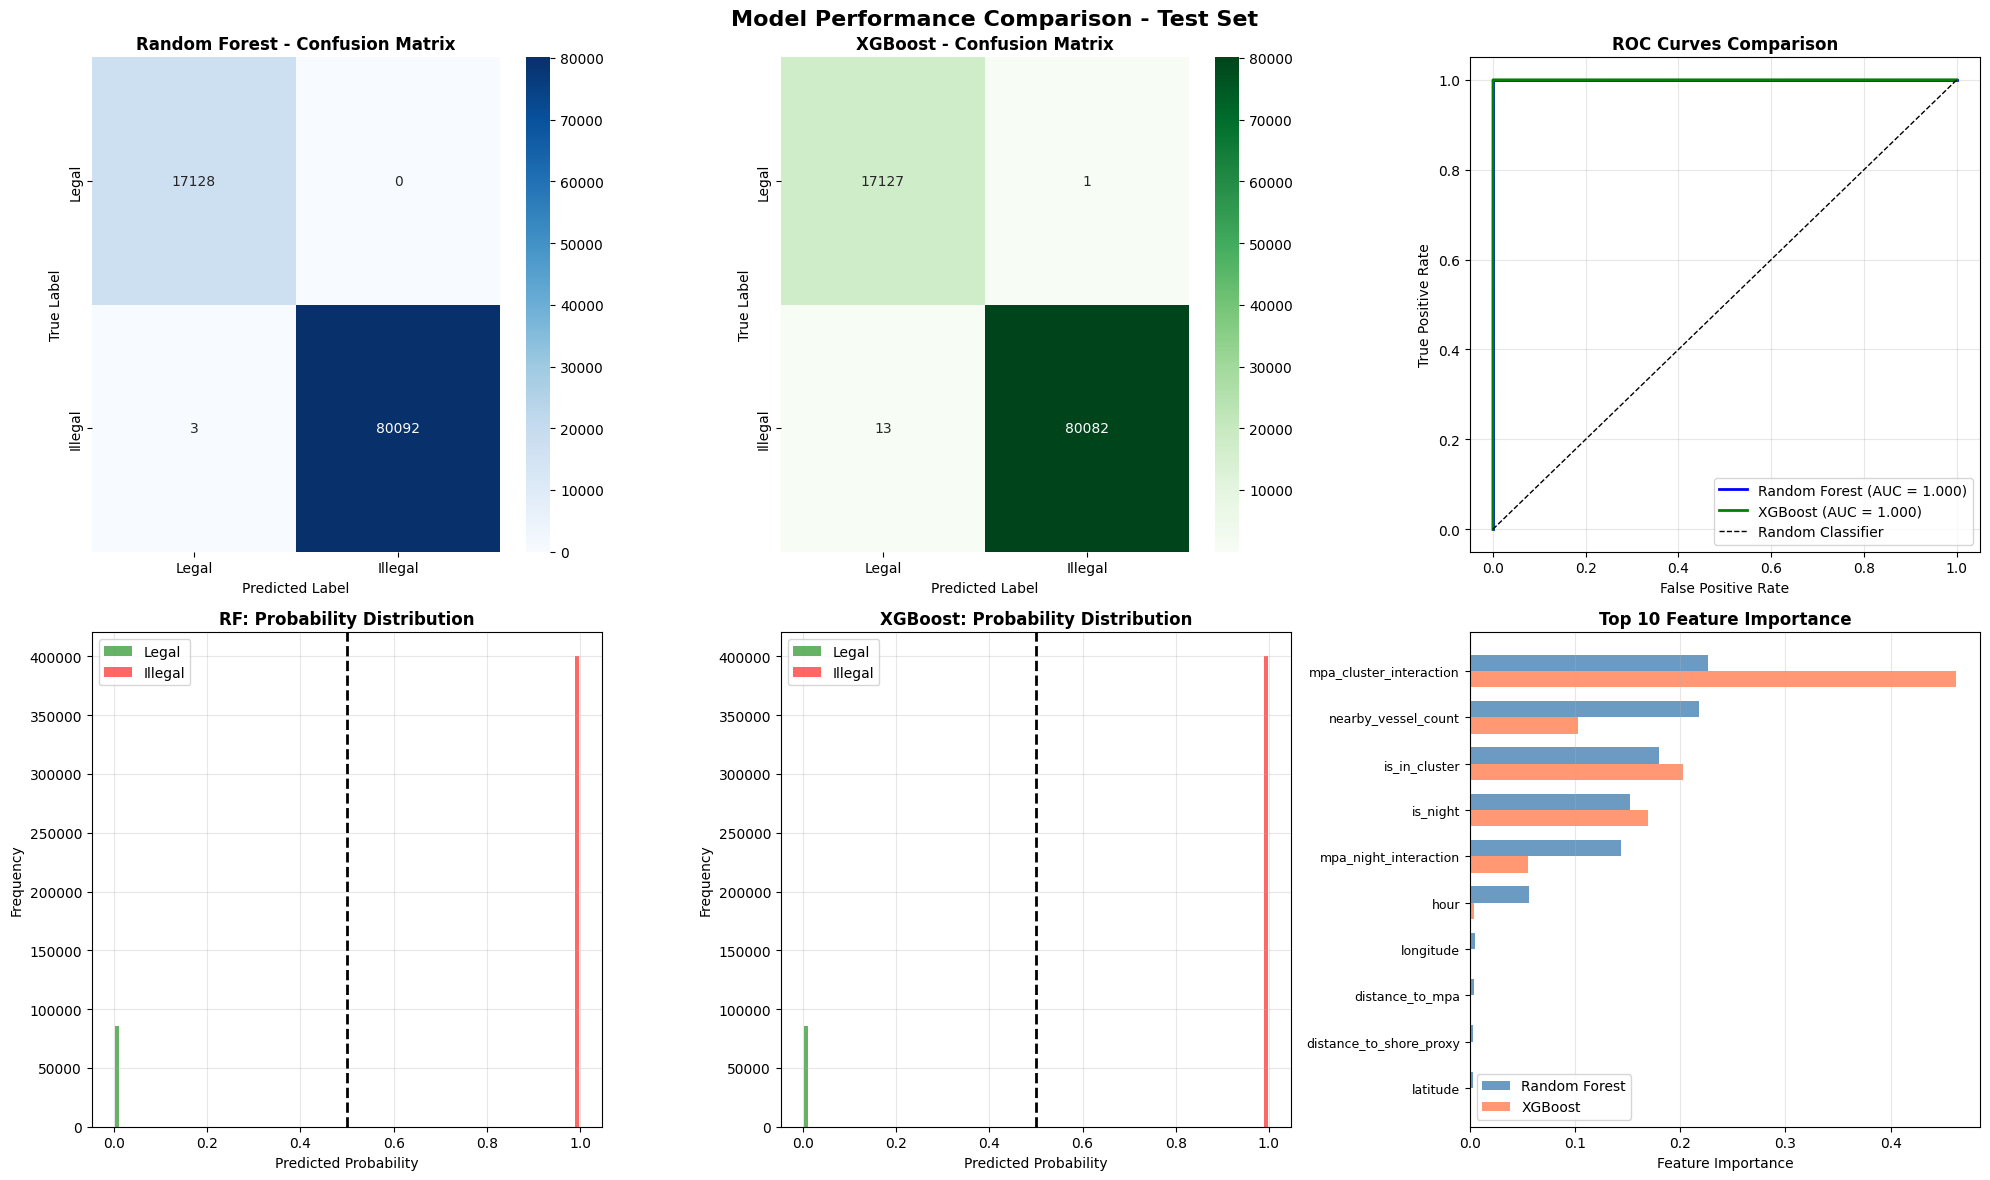

In [31]:
# ============================================================================
# VISUALIZATION 1: MODEL PERFORMANCE COMPARISON
# ============================================================================
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Model Performance Comparison - Test Set', fontsize=16, fontweight='bold')

# Confusion Matrix - Random Forest
cm_rf = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Legal', 'Illegal'], yticklabels=['Legal', 'Illegal'])
axes[0, 0].set_title('Random Forest - Confusion Matrix', fontweight='bold')
axes[0, 0].set_ylabel('True Label')
axes[0, 0].set_xlabel('Predicted Label')

# Confusion Matrix - XGBoost
cm_xgb = confusion_matrix(y_test, xgb_pred)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', ax=axes[0, 1],
            xticklabels=['Legal', 'Illegal'], yticklabels=['Legal', 'Illegal'])
axes[0, 1].set_title('XGBoost - Confusion Matrix', fontweight='bold')
axes[0, 1].set_ylabel('True Label')
axes[0, 1].set_xlabel('Predicted Label')

# ROC Curves
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred_proba)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_pred_proba)

axes[0, 2].plot(fpr_rf, tpr_rf, 'b-', linewidth=2,
                label=f'Random Forest (AUC = {roc_auc_score(y_test, rf_pred_proba):.3f})')
axes[0, 2].plot(fpr_xgb, tpr_xgb, 'g-', linewidth=2,
                label=f'XGBoost (AUC = {roc_auc_score(y_test, xgb_pred_proba):.3f})')
axes[0, 2].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[0, 2].set_xlabel('False Positive Rate')
axes[0, 2].set_ylabel('True Positive Rate')
axes[0, 2].set_title('ROC Curves Comparison', fontweight='bold')
axes[0, 2].legend(loc='lower right')
axes[0, 2].grid(True, alpha=0.3)

# Probability Distribution - RF
axes[1, 0].hist([df_model[df_model['illegal_fishing']==0]['rf_probability'].dropna(),
                 df_model[df_model['illegal_fishing']==1]['rf_probability'].dropna()],
                bins=50, alpha=0.6, label=['Legal', 'Illegal'], color=['green', 'red'])
axes[1, 0].axvline(x=0.5, color='black', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Probability')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('RF: Probability Distribution', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Probability Distribution - XGBoost
axes[1, 1].hist([df_model[df_model['illegal_fishing']==0]['xgb_probability'].dropna(),
                 df_model[df_model['illegal_fishing']==1]['xgb_probability'].dropna()],
                bins=50, alpha=0.6, label=['Legal', 'Illegal'], color=['green', 'red'])
axes[1, 1].axvline(x=0.5, color='black', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Predicted Probability')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('XGBoost: Probability Distribution', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Feature Importance Comparison
top_n = min(10, len(feature_columns))
comparison_df = pd.DataFrame({
    'Feature': feature_columns,
    'Random Forest': rf_model.feature_importances_,
    'XGBoost': xgb_model.feature_importances_
}).sort_values('Random Forest', ascending=False).head(top_n)

x = np.arange(len(comparison_df))
width = 0.35
axes[1, 2].barh(x - width/2, comparison_df['Random Forest'], width,
                label='Random Forest', alpha=0.8, color='steelblue')
axes[1, 2].barh(x + width/2, comparison_df['XGBoost'], width,
                label='XGBoost', alpha=0.8, color='coral')
axes[1, 2].set_yticks(x)
axes[1, 2].set_yticklabels(comparison_df['Feature'], fontsize=9)
axes[1, 2].set_xlabel('Feature Importance')
axes[1, 2].set_title(f'Top {top_n} Feature Importance', fontweight='bold')
axes[1, 2].legend()
axes[1, 2].invert_yaxis()
axes[1, 2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/model_performance_comparison.png', dpi=300, bbox_inches='tight')
print("  ✓ Model performance comparison saved")



  - Creating geographic visualizations...
  ✓ Geographic analysis saved


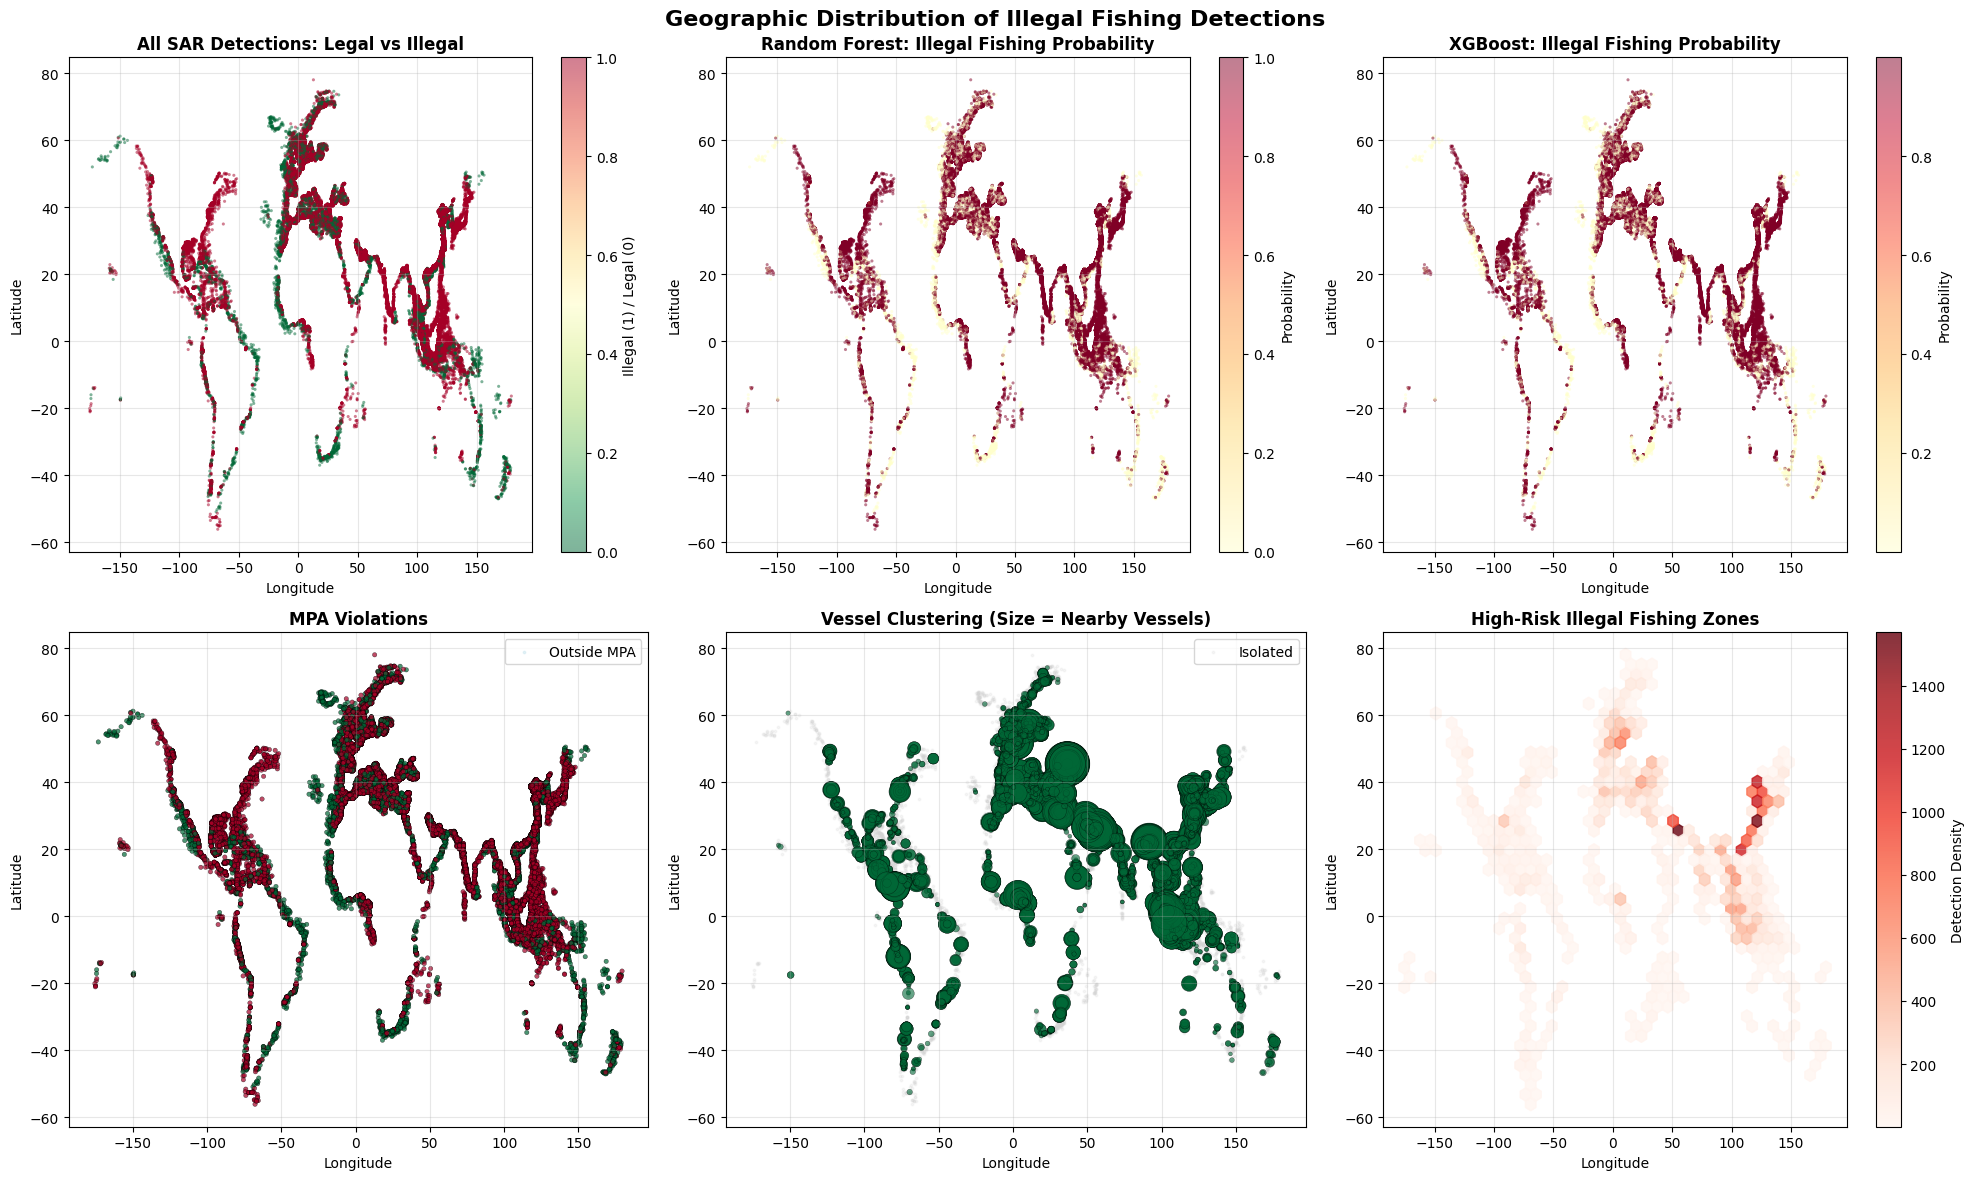

In [32]:
# ============================================================================
# VISUALIZATION 2: GEOGRAPHIC ANALYSIS
# ============================================================================
print("  - Creating geographic visualizations...")

fig = plt.figure(figsize=(20, 12))
fig.suptitle('Geographic Distribution of Illegal Fishing Detections', fontsize=16, fontweight='bold')

# Sample data for visualization (use subset if too large)
sample_size = min(50000, len(df_model))
df_viz = df_model.sample(n=sample_size, random_state=42)

# Plot 1: All Detections
ax1 = plt.subplot(2, 3, 1)
scatter1 = ax1.scatter(df_viz['longitude'], df_viz['latitude'],
                       c=df_viz['illegal_fishing'], cmap='RdYlGn_r',
                       s=5, alpha=0.5, edgecolors='none')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('All SAR Detections: Legal vs Illegal', fontweight='bold')
ax1.grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('Illegal (1) / Legal (0)')

# Plot 2: RF Probability Heatmap
ax2 = plt.subplot(2, 3, 2)
scatter2 = ax2.scatter(df_viz['longitude'], df_viz['latitude'],
                       c=df_viz['rf_probability'], cmap='YlOrRd',
                       s=5, alpha=0.5, edgecolors='none')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('Random Forest: Illegal Fishing Probability', fontweight='bold')
ax2.grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.set_label('Probability')

# Plot 3: XGBoost Probability Heatmap
ax3 = plt.subplot(2, 3, 3)
scatter3 = ax3.scatter(df_viz['longitude'], df_viz['latitude'],
                       c=df_viz['xgb_probability'], cmap='YlOrRd',
                       s=5, alpha=0.5, edgecolors='none')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax3.set_title('XGBoost: Illegal Fishing Probability', fontweight='bold')
ax3.grid(True, alpha=0.3)
cbar3 = plt.colorbar(scatter3, ax=ax3)
cbar3.set_label('Probability')

# Plot 4: MPA Violations
ax4 = plt.subplot(2, 3, 4)
mpa_detections = df_viz[df_viz['in_mpa'] == 1]
non_mpa_detections = df_viz[df_viz['in_mpa'] == 0]
ax4.scatter(non_mpa_detections['longitude'], non_mpa_detections['latitude'],
           c='lightblue', s=3, alpha=0.3, label='Outside MPA')
ax4.scatter(mpa_detections['longitude'], mpa_detections['latitude'],
           c=mpa_detections['illegal_fishing'], cmap='RdYlGn_r',
           s=10, alpha=0.7, edgecolors='black', linewidth=0.3)
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
ax4.set_title('MPA Violations', fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.legend()

# Plot 5: Vessel Clustering
ax5 = plt.subplot(2, 3, 5)
clusters = df_viz[df_viz['is_in_cluster'] == 1]
non_clusters = df_viz[df_viz['is_in_cluster'] == 0]
ax5.scatter(non_clusters['longitude'], non_clusters['latitude'],
           c='lightgray', s=3, alpha=0.2, label='Isolated')
if len(clusters) > 0:
    ax5.scatter(clusters['longitude'], clusters['latitude'],
               c=clusters['illegal_fishing'], cmap='RdYlGn_r',
               s=clusters['nearby_vessel_count']*2, alpha=0.6,
               edgecolors='black', linewidth=0.3)
ax5.set_xlabel('Longitude')
ax5.set_ylabel('Latitude')
ax5.set_title('Vessel Clustering (Size = Nearby Vessels)', fontweight='bold')
ax5.grid(True, alpha=0.3)
ax5.legend()

# Plot 6: High-Risk Zones (Hexbin)
ax6 = plt.subplot(2, 3, 6)
illegal_df = df_viz[df_viz['illegal_fishing']==1]
if len(illegal_df) > 0:
    hexbin = ax6.hexbin(illegal_df['longitude'], illegal_df['latitude'],
                        gridsize=40, cmap='Reds', alpha=0.8, mincnt=1)
    cbar6 = plt.colorbar(hexbin, ax=ax6)
    cbar6.set_label('Detection Density')
ax6.set_xlabel('Longitude')
ax6.set_ylabel('Latitude')
ax6.set_title('High-Risk Illegal Fishing Zones', fontweight='bold')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/geographic_analysis.png', dpi=300, bbox_inches='tight')
print("  ✓ Geographic analysis saved")

  - Creating temporal visualizations...
  ✓ Temporal analysis saved


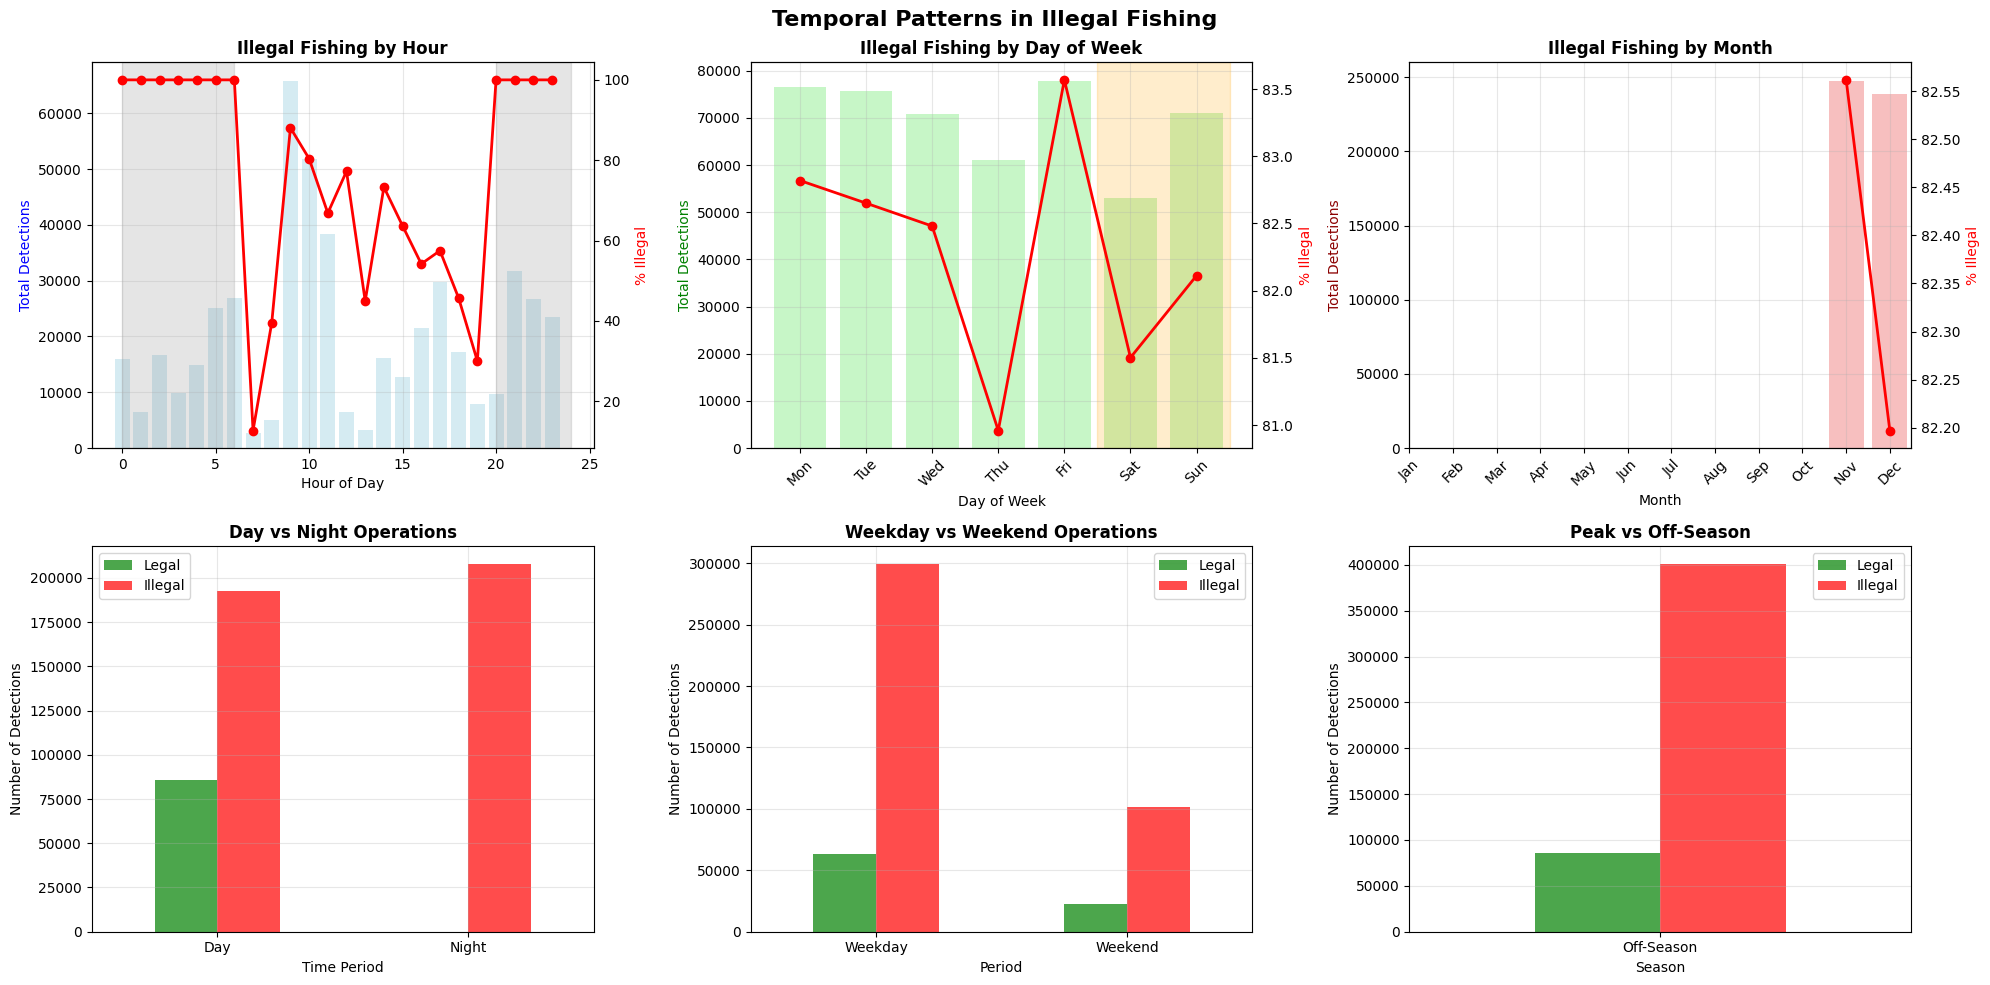

In [34]:
# ============================================================================
# VISUALIZATION 3: TEMPORAL ANALYSIS
# ============================================================================
print("  - Creating temporal visualizations...")

fig = plt.figure(figsize=(20, 10))
fig.suptitle('Temporal Patterns in Illegal Fishing', fontsize=16, fontweight='bold')

# Hourly Distribution
ax1 = plt.subplot(2, 3, 1)
hourly_data = df_model.groupby('hour')['illegal_fishing'].agg(['sum', 'count', 'mean'])
ax1.bar(hourly_data.index, hourly_data['count'], alpha=0.5, color='lightblue', label='Total')
ax1_twin = ax1.twinx()
ax1_twin.plot(hourly_data.index, hourly_data['mean']*100, 'ro-', linewidth=2, markersize=6)
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Total Detections', color='blue')
ax1_twin.set_ylabel('% Illegal', color='red')
ax1.set_title('Illegal Fishing by Hour', fontweight='bold')
ax1.axvspan(0, 6, alpha=0.2, color='gray')
ax1.axvspan(20, 24, alpha=0.2, color='gray')
ax1.grid(True, alpha=0.3)

# Day of Week Distribution
ax2 = plt.subplot(2, 3, 2)
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dow_data = df_model.groupby('day_of_week')['illegal_fishing'].agg(['sum', 'count', 'mean'])
ax2.bar(dow_data.index, dow_data['count'], alpha=0.5, color='lightgreen')
ax2_twin = ax2.twinx()
ax2_twin.plot(dow_data.index, dow_data['mean']*100, 'ro-', linewidth=2, markersize=6)
ax2.set_xlabel('Day of Week')
ax2.set_ylabel('Total Detections', color='green')
ax2_twin.set_ylabel('% Illegal', color='red')
ax2.set_title('Illegal Fishing by Day of Week', fontweight='bold')
ax2.set_xticks(range(7))
ax2.set_xticklabels(days, rotation=45)
ax2.axvspan(4.5, 6.5, alpha=0.2, color='orange')
ax2.grid(True, alpha=0.3)

# Monthly Distribution
ax3 = plt.subplot(2, 3, 3)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_data = df_model.groupby('month')['illegal_fishing'].agg(['sum', 'count', 'mean'])
ax3.bar(month_data.index, month_data['count'], alpha=0.5, color='lightcoral')
ax3_twin = ax3.twinx()
ax3_twin.plot(month_data.index, month_data['mean']*100, 'ro-', linewidth=2, markersize=6)
ax3.set_xlabel('Month')
ax3.set_ylabel('Total Detections', color='darkred')
ax3_twin.set_ylabel('% Illegal', color='red')
ax3.set_title('Illegal Fishing by Month', fontweight='bold')
ax3.set_xticks(range(1, 13))
ax3.set_xticklabels(months, rotation=45)
ax3.grid(True, alpha=0.3)

# Night vs Day
ax4 = plt.subplot(2, 3, 4)
night_data = df_model.groupby(['is_night', 'illegal_fishing']).size().unstack(fill_value=0)
night_data.plot(kind='bar', ax=ax4, color=['green', 'red'], alpha=0.7)
ax4.set_xlabel('Time Period')
ax4.set_ylabel('Number of Detections')
ax4.set_title('Day vs Night Operations', fontweight='bold')
ax4.set_xticklabels(['Day', 'Night'], rotation=0)
ax4.legend(['Legal', 'Illegal'])
ax4.grid(True, alpha=0.3)

# Weekend vs Weekday
ax5 = plt.subplot(2, 3, 5)
weekend_data = df_model.groupby(['is_weekend', 'illegal_fishing']).size().unstack(fill_value=0)
weekend_data.plot(kind='bar', ax=ax5, color=['green', 'red'], alpha=0.7)
ax5.set_xlabel('Period')
ax5.set_ylabel('Number of Detections')
ax5.set_title('Weekday vs Weekend Operations', fontweight='bold')
ax5.set_xticklabels(['Weekday', 'Weekend'], rotation=0)
ax5.legend(['Legal', 'Illegal'])
ax5.grid(True, alpha=0.3)

# Peak Fishing Season
ax6 = plt.subplot(2, 3, 6)
season_data = df_model.groupby(['is_peak_fishing_season', 'illegal_fishing']).size().unstack(fill_value=0)

if not season_data.empty:
    season_data.plot(kind='bar', ax=ax6, color=['green', 'red'], alpha=0.7)
    ax6.set_xlabel('Season')
    ax6.set_ylabel('Number of Detections')
    ax6.set_title('Peak vs Off-Season', fontweight='bold')

    # Dynamically create labels based on existing index values
    current_season_labels = []
    for idx_val in season_data.index:
        if idx_val == 0:
            current_season_labels.append('Off-Season')
        elif idx_val == 1:
            current_season_labels.append('Peak Season')

    ax6.set_xticklabels(current_season_labels, rotation=0)
    ax6.legend(['Legal', 'Illegal'])
    ax6.grid(True, alpha=0.3)
else:
    ax6.text(0.5, 0.5, 'No data for Peak Fishing Season', horizontalalignment='center', verticalalignment='center', transform=ax6.transAxes)
    ax6.set_title('Peak vs Off-Season', fontweight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/temporal_analysis.png', dpi=300, bbox_inches='tight')
print("  ✓ Temporal analysis saved")

  - Creating feature analysis visualizations...
  ✓ Feature analysis saved


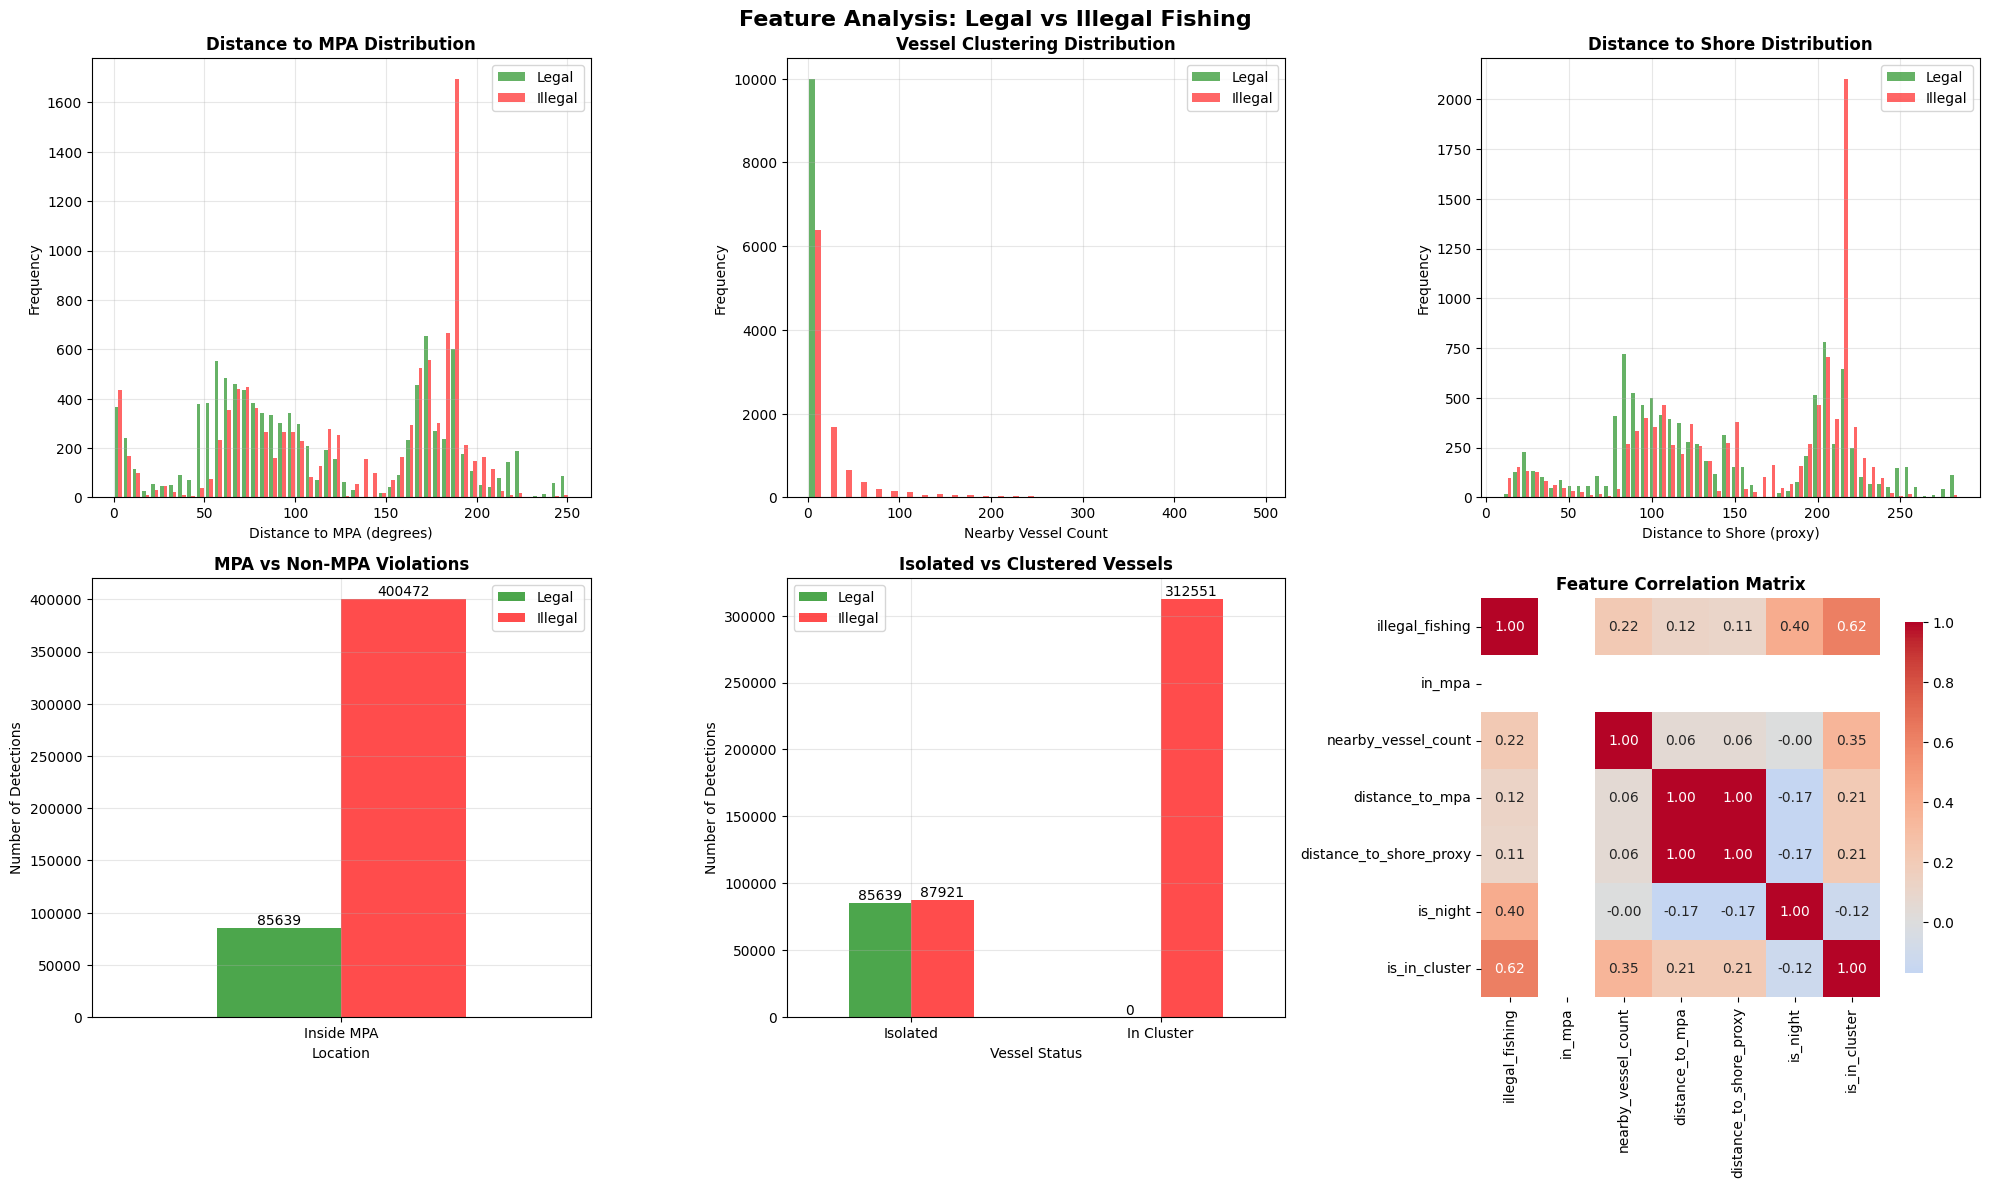

In [36]:
# ============================================================================
# VISUALIZATION 4: FEATURE ANALYSIS
# ============================================================================
print("  - Creating feature analysis visualizations...")

fig = plt.figure(figsize=(20, 12))
fig.suptitle('Feature Analysis: Legal vs Illegal Fishing', fontsize=16, fontweight='bold')

# Distance to MPA
ax1 = plt.subplot(2, 3, 1)
illegal_dist = df_model[df_model['illegal_fishing']==1]['distance_to_mpa'].dropna()
legal_dist = df_model[df_model['illegal_fishing']==0]['distance_to_mpa'].dropna()
ax1.hist([legal_dist.sample(min(10000, len(legal_dist))),
          illegal_dist.sample(min(10000, len(illegal_dist)))],
         bins=50, alpha=0.6, label=['Legal', 'Illegal'], color=['green', 'red'])
ax1.set_xlabel('Distance to MPA (degrees)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distance to MPA Distribution', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Nearby Vessel Count
ax2 = plt.subplot(2, 3, 2)
illegal_nearby = df_model[df_model['illegal_fishing']==1]['nearby_vessel_count'].dropna()
legal_nearby = df_model[df_model['illegal_fishing']==0]['nearby_vessel_count'].dropna()
ax2.hist([legal_nearby.sample(min(10000, len(legal_nearby))),
          illegal_nearby.sample(min(10000, len(illegal_nearby)))],
         bins=30, alpha=0.6, label=['Legal', 'Illegal'], color=['green', 'red'])
ax2.set_xlabel('Nearby Vessel Count')
ax2.set_ylabel('Frequency')
ax2.set_title('Vessel Clustering Distribution', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Distance to Shore
ax3 = plt.subplot(2, 3, 3)
illegal_shore = df_model[df_model['illegal_fishing']==1]['distance_to_shore_proxy'].dropna()
legal_shore = df_model[df_model['illegal_fishing']==0]['distance_to_shore_proxy'].dropna()
ax3.hist([legal_shore.sample(min(10000, len(legal_shore))),
          illegal_shore.sample(min(10000, len(illegal_shore)))],
         bins=50, alpha=0.6, label=['Legal', 'Illegal'], color=['green', 'red'])
ax3.set_xlabel('Distance to Shore (proxy)')
ax3.set_ylabel('Frequency')
ax3.set_title('Distance to Shore Distribution', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# MPA vs Non-MPA
ax4 = plt.subplot(2, 3, 4)
mpa_stats = df_model.groupby(['in_mpa', 'illegal_fishing']).size().unstack(fill_value=0)

if not mpa_stats.empty:
    mpa_stats.plot(kind='bar', ax=ax4, color=['green', 'red'], alpha=0.7)
    ax4.set_xlabel('Location')
    ax4.set_ylabel('Number of Detections')
    ax4.set_title('MPA vs Non-MPA Violations', fontweight='bold')

    current_mpa_labels = []
    for idx_val in mpa_stats.index:
        if idx_val == 0:
            current_mpa_labels.append('Outside MPA')
        elif idx_val == 1:
            current_mpa_labels.append('Inside MPA')
    ax4.set_xticklabels(current_mpa_labels, rotation=0)
    ax4.legend(['Legal', 'Illegal'])
    for container in ax4.containers:
        ax4.bar_label(container, fmt='%d')
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'No data for MPA vs Non-MPA', horizontalalignment='center', verticalalignment='center', transform=ax4.transAxes)
    ax4.set_title('MPA vs Non-MPA Violations', fontweight='bold')

# Clustering Analysis
ax5 = plt.subplot(2, 3, 5)
cluster_stats = df_model.groupby(['is_in_cluster', 'illegal_fishing']).size().unstack(fill_value=0)
cluster_stats.plot(kind='bar', ax=ax5, color=['green', 'red'], alpha=0.7)
ax5.set_xlabel('Vessel Status')
ax5.set_ylabel('Number of Detections')
ax5.set_title('Isolated vs Clustered Vessels', fontweight='bold')
ax5.set_xticklabels(['Isolated', 'In Cluster'], rotation=0)
ax5.legend(['Legal', 'Illegal'])
for container in ax5.containers:
    ax5.bar_label(container, fmt='%d')
ax5.grid(True, alpha=0.3)

# Correlation Heatmap
ax6 = plt.subplot(2, 3, 6)
corr_features = ['illegal_fishing', 'in_mpa', 'nearby_vessel_count', 'distance_to_mpa',
                 'distance_to_shore_proxy', 'is_night', 'is_in_cluster']
corr_matrix = df_model[corr_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            ax=ax6, cbar_kws={'shrink': 0.8}, square=True)
ax6.set_title('Feature Correlation Matrix', fontweight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/feature_analysis.png', dpi=300, bbox_inches='tight')
print("  ✓ Feature analysis saved")

In [37]:
# ============================================================================
# STEP 11: SAVE RESULTS AND GENERATE REPORT
# ============================================================================
print("\n[STEP 11] Saving models and generating report...")

# Save models
import joblib
joblib.dump(rf_model, '/content/drive/MyDrive/random_forest_sar_fishing.pkl')
joblib.dump(xgb_model, '/content/drive/MyDrive/xgboost_sar_fishing.pkl')
joblib.dump(scaler, '/content/drive/MyDrive/feature_scaler_sar.pkl')
print("  ✓ Models saved")

# Save feature importance
rf_feature_importance.to_csv('/content/drive/MyDrive/rf_feature_importance_sar.csv', index=False)
xgb_feature_importance.to_csv('/content/drive/MyDrive/xgb_feature_importance_sar.csv', index=False)
print("  ✓ Feature importance saved")

# Save processed dataset (sample if too large)
if len(df_model) > 100000:
    df_model.sample(100000, random_state=42).to_csv('/content/drive/MyDrive/processed_sar_fishing_data_sample.csv', index=False)
    print("  ✓ Processed dataset sample (100k records) saved")
else:
    df_model.to_csv('/content/drive/MyDrive/processed_sar_fishing_data.csv', index=False)
    print("  ✓ Processed dataset saved")

# Generate comprehensive report
report = f"""
{'='*80}
ILLEGAL FISHING DETECTION - COMPREHENSIVE ANALYSIS REPORT
{'='*80}

DATASET OVERVIEW:
{'='*80}
Total SAR Detections Processed: {len(df_model):,}
Training Set Size: {len(X_train):,} samples
Test Set Size: {len(X_test):,} samples

CLASS DISTRIBUTION:
Legal Fishing Cases: {(df_model['illegal_fishing']==0).sum():,} ({(df_model['illegal_fishing']==0).mean()*100:.2f}%)
Illegal Fishing Cases: {(df_model['illegal_fishing']==1).sum():,} ({(df_model['illegal_fishing']==1).mean()*100:.2f}%)

SPATIAL ANALYSIS:
{'='*80}
Detections in MPAs: {(df_model['in_mpa']==1).sum():,}
Illegal Activity in MPAs: {df_model[df_model['in_mpa']==1]['illegal_fishing'].sum():,}
MPA Violation Rate: {df_model[df_model['in_mpa']==1]['illegal_fishing'].mean()*100:.2f}%

Clustered Vessels: {(df_model['is_in_cluster']==1).sum():,}
Illegal Activity in Clusters: {df_model[df_model['is_in_cluster']==1]['illegal_fishing'].sum():,}
Cluster Violation Rate: {df_model[df_model['is_in_cluster']==1]['illegal_fishing'].mean()*100:.2f}%

TEMPORAL PATTERNS:
{'='*80}
Night Detections: {(df_model['is_night']==1).sum():,}
Night Violations: {df_model[df_model['is_night']==1]['illegal_fishing'].sum():,}
Night Violation Rate: {df_model[df_model['is_night']==1]['illegal_fishing'].mean()*100:.2f}%

Weekend Detections: {(df_model['is_weekend']==1).sum():,}
Weekend Violations: {df_model[df_model['is_weekend']==1]['illegal_fishing'].sum():,}
Weekend Violation Rate: {df_model[df_model['is_weekend']==1]['illegal_fishing'].mean()*100:.2f}%

Peak Season Detections: {(df_model['is_peak_fishing_season']==1).sum():,}
Peak Season Violations: {df_model[df_model['is_peak_fishing_season']==1]['illegal_fishing'].sum():,}
Peak Season Violation Rate: {df_model[df_model['is_peak_fishing_season']==1]['illegal_fishing'].mean()*100:.2f}%

RANDOM FOREST MODEL PERFORMANCE (TEST SET):
{'='*80}
Accuracy: {(rf_pred == y_test).mean():.4f}
Precision (Illegal): {cm_rf[1,1]/(cm_rf[1,1]+cm_rf[0,1]):.4f}
Recall (Illegal): {cm_rf[1,1]/(cm_rf[1,1]+cm_rf[1,0]):.4f}
F1-Score (Illegal): {2*(cm_rf[1,1]/(cm_rf[1,1]+cm_rf[0,1]))*(cm_rf[1,1]/(cm_rf[1,1]+cm_rf[1,0]))/((cm_rf[1,1]/(cm_rf[1,1]+cm_rf[0,1]))+(cm_rf[1,1]/(cm_rf[1,1]+cm_rf[1,0]))):.4f}
ROC-AUC Score: {roc_auc_score(y_test, rf_pred_proba):.4f}

Top 5 Most Important Features (RF):
{'-'*80}
"""

for idx, row in rf_feature_importance.head(5).iterrows():
    report += f"  {idx+1}. {row['feature']}: {row['importance']:.4f}\n"

report += f"""
XGBOOST MODEL PERFORMANCE (TEST SET):
{'='*80}
Accuracy: {(xgb_pred == y_test).mean():.4f}
Precision (Illegal): {cm_xgb[1,1]/(cm_xgb[1,1]+cm_xgb[0,1]):.4f}
Recall (Illegal): {cm_xgb[1,1]/(cm_xgb[1,1]+cm_xgb[1,0]):.4f}
F1-Score (Illegal): {2*(cm_xgb[1,1]/(cm_xgb[1,1]+cm_xgb[0,1]))*(cm_xgb[1,1]/(cm_xgb[1,1]+cm_xgb[1,0]))/((cm_xgb[1,1]/(cm_xgb[1,1]+cm_xgb[0,1]))+(cm_xgb[1,1]/(cm_xgb[1,1]+cm_xgb[1,0]))):.4f}
ROC-AUC Score: {roc_auc_score(y_test, xgb_pred_proba):.4f}

Top 5 Most Important Features (XGBoost):
{'-'*80}
"""

for idx, row in xgb_feature_importance.head(5).iterrows():
    report += f"  {idx+1}. {row['feature']}: {row['importance']:.4f}\n"

report += f"""
MODEL AGREEMENT ANALYSIS:
{'='*80}
Both Models Predict Illegal: {((df_model['rf_prediction']==1) & (df_model['xgb_prediction']==1)).sum():,}
Both Models Predict Legal: {((df_model['rf_prediction']==0) & (df_model['xgb_prediction']==0)).sum():,}
RF Only Predicts Illegal: {((df_model['rf_prediction']==1) & (df_model['xgb_prediction']==0)).sum():,}
XGB Only Predicts Illegal: {((df_model['rf_prediction']==0) & (df_model['xgb_prediction']==1)).sum():,}
Overall Agreement: {((df_model['rf_prediction']==df_model['xgb_prediction']).sum() / len(df_model))*100:.2f}%

OUTPUT FILES GENERATED:
{'='*80}
✓ random_forest_sar_fishing.pkl
✓ xgboost_sar_fishing.pkl
✓ feature_scaler_sar.pkl
✓ rf_feature_importance_sar.csv
✓ xgb_feature_importance_sar.csv
✓ processed_sar_fishing_data.csv (or sample)
✓ model_performance_comparison.png
✓ geographic_analysis.png
✓ temporal_analysis.png
✓ feature_analysis.png

RECOMMENDATIONS:
{'='*80}
1. High-Risk Areas: Focus enforcement on MPA zones with {df_model[df_model['in_mpa']==1]['illegal_fishing'].mean()*100:.1f}% violation rate
2. Temporal Focus: Increase monitoring during night hours ({df_model[df_model['is_night']==1]['illegal_fishing'].mean()*100:.1f}% violation rate)
3. Vessel Clustering: Investigate clustered vessels ({df_model[df_model['is_in_cluster']==1]['illegal_fishing'].mean()*100:.1f}% violation rate)
4. Both models show strong agreement ({((df_model['rf_prediction']==df_model['xgb_prediction']).sum() / len(df_model))*100:.1f}%), increasing confidence in predictions

IMPORTANT NOTES:
{'='*80}
⚠ The target variable is based on synthetic labels using suspicious pattern heuristics
⚠ For production use, this model MUST be trained on actual ground truth data
⚠ Current labels are for demonstration and initial pattern detection only
⚠ Validate predictions with domain experts and enforcement records

{'='*80}
Analysis completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
{'='*80}
"""

# Save report
with open('/content/drive/MyDrive/illegal_fishing_analysis_report.txt', 'w') as f:
    f.write(report)

print(report)
print("\n  ✓ Comprehensive report saved to 'illegal_fishing_analysis_report.txt'")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "=" * 80)
print("PIPELINE COMPLETED SUCCESSFULLY!")
print("=" * 80)
print(f"\nProcessed {len(df_model):,} SAR detections")
print(f"Trained 2 machine learning models")
print(f"Generated 4 comprehensive visualizations")
print(f"Created detailed analysis report")
print("\nAll files saved to Google Drive")
print("=" * 80)


[STEP 11] Saving models and generating report...
  ✓ Models saved
  ✓ Feature importance saved
  ✓ Processed dataset sample (100k records) saved

ILLEGAL FISHING DETECTION - COMPREHENSIVE ANALYSIS REPORT

DATASET OVERVIEW:
Total SAR Detections Processed: 486,111
Training Set Size: 388,888 samples
Test Set Size: 97,223 samples

CLASS DISTRIBUTION:
Legal Fishing Cases: 85,639 (17.62%)
Illegal Fishing Cases: 400,472 (82.38%)

SPATIAL ANALYSIS:
Detections in MPAs: 486,111
Illegal Activity in MPAs: 400,472
MPA Violation Rate: 82.38%

Clustered Vessels: 312,551
Illegal Activity in Clusters: 312,551
Cluster Violation Rate: 100.00%

TEMPORAL PATTERNS:
Night Detections: 207,616
Night Violations: 207,616
Night Violation Rate: 100.00%

Weekend Detections: 123,959
Weekend Violations: 101,462
Weekend Violation Rate: 81.85%

Peak Season Detections: 0
Peak Season Violations: 0
Peak Season Violation Rate: nan%

RANDOM FOREST MODEL PERFORMANCE (TEST SET):
Accuracy: 1.0000
Precision (Illegal): 1.0000
R